# CLIMB+CLIFF at on a simulated AML dataset 

Here we used deconvoluted cell-type proportions and deconvoluted expression at high-resolution yielded by CLIMB, as input for CLIFF. CLIFF then output a prediction of cell-type drug sensitivity for each patient, each cell-type and each drug. 

In [2]:
library(glmnet) ; library(ggplot2) ; library(reshape2)
library(CoreGx) ; library(PharmacoGx) ; 
library(sigmoid); library(ComplexHeatmap) ; library(circlize)
library(ggrepel); library(ggpmisc); library(ramify)
library(RColorBrewer) ; library(ggpubr)
# We load CLIMB / CLIFF library
library(ClimbTheCliff)

In [3]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,colnames(true_p)]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,colnames(true_p)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,colnames(true_p)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,colnames(true_p)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,colnames(true_p)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,colnames(true_p)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,colnames(true_p)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture')[,colnames(true_p)]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_p) ; true_prop_rows = rownames(true_p)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}   
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
}                                                                                                     ## Generate cell-type drug sensitivity as raw values for 7 doses
generate_celltype_drug_sensitivity <- function(low_decay = c('Monolike', 'Mono', 'ProMonolike'),
                                               high_decay = c('HSC', 'HSClike', 'Prog', 'Proglike'),
                                               props, signal_to_noise_ratio = 20){
    celltypes = colnames(props)
    celltype_sensitivity = matrix(0,length(celltypes),7)
    decays = list()
    for(k in 1:length(celltypes)){
        ct = celltypes[k]
        if(ct %in% low_decay){
            set.seed(k)
            decays[[k]] = runif(1,0.7,1.0)
        } else if(ct %in% high_decay) {
            set.seed(k)
            decays[[k]] = runif(1,6.0,8.0)
        } else  {
            set.seed(k)
            decays[[k]] = runif(1,1.2,2.2)
        }

        for(d in 1:7){
            celltype_sensitivity[k,d] = 1/(1 + exp(decays[[k]]*d - 8))
        }
    }
    decays = num(decays)
    ### Add random noise
    Signal = celltype_sensitivity
    Noise = randn(nrow(celltype_sensitivity),ncol(celltype_sensitivity))
    Signal_Power = sum(abs(Signal)*abs(Signal))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
    Noise_Power = sum(abs(Noise)*abs(Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
    Initial_SNR = 10*(log10(Signal_Power/Noise_Power));
    K = (Signal_Power/Noise_Power)*10^(-signal_to_noise_ratio/10)
    New_Noise = sqrt(K)*Noise
    New_Noise_Power = sum(abs(New_Noise)*abs(New_Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity))
    New_SNR = 10*(log10(Signal_Power/New_Noise_Power))
    Noisy_Signal = Signal + New_Noise;
    Noisy_Signal[Noisy_Signal < 0.0] = 0.0
    Noisy_Signal[Noisy_Signal > 1.0] = 1.0
    ## Reformat and returnk
    celltype_sensitivity = Noisy_Signal
    rownames(celltype_sensitivity) = celltypes
    colnames(celltype_sensitivity) = c(1:7)
    celltype_sensitivity = data.frame(celltype_sensitivity)
    celltype_sensitivity$sample = rownames(celltype_sensitivity)
    colnames(celltype_sensitivity) = gsub('X', 'd', colnames(celltype_sensitivity))
    melt_celltype_sensitivity = melt(celltype_sensitivity)
    celltype_sensitivity_auc = aggregate(melt_celltype_sensitivity$value, list(melt_celltype_sensitivity$sample), computeAUC_)
    colnames(celltype_sensitivity_auc) = c('sample', 'auc')
    rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample
    return(list(as.matrix(celltype_sensitivity[,-8]),celltype_sensitivity_auc))
}

generate_bulk_drug_sensitivity <- function(celltype_ds, props){
    all_patients = rownames(props)
    celltypes = colnames(props)
    bulk_survivals = list()
    tab_ct = props*5000
    set.seed(1)
    for(n in 1:length(all_patients)){
        this_patient = rownames(props)[n]
        celltype_sensitivity_1p = matrix(0,length(celltypes),7)
        tab_ct_1p = tab_ct[n,]
        counts  = tab_ct[n,]
        for(k in 1:length(celltypes)){
            counts_k  = counts[k]
            for(d in 1:7){
                celltype_sensitivity_1p[k,d] = num(round(counts_k*celltype_ds[k,d]))
            }
        }
        rownames(celltype_sensitivity_1p) = celltypes
        colnames(celltype_sensitivity_1p) = c(1:7)
        celltype_sensitivity_1p_n = apply(celltype_sensitivity_1p, 2, function(x) x/tab_ct_1p)
        celltype_sensitivity_1p_n[is.na(celltype_sensitivity_1p_n)] <- 0
        bulk_sensitivity = colSums(celltype_sensitivity_1p) / sum(tab_ct_1p)
        bulk_survivals[[n]] = bulk_sensitivity
    }
    bulk_drug_sensitivity = do.call(rbind, bulk_survivals)
    rownames(bulk_drug_sensitivity) = all_patients
    bulk_drug_sensitivity = data.frame(bulk_drug_sensitivity)
    bulk_drug_sensitivity$sample = rownames(bulk_drug_sensitivity)
    colnames(bulk_drug_sensitivity) = gsub('X', 'd', colnames(bulk_drug_sensitivity))
    melt_drug_sensitivity_data = melt(bulk_drug_sensitivity)                                    
    drug_sensitivity_auc = aggregate(melt_drug_sensitivity_data$value, list(melt_drug_sensitivity_data$sample), computeAUC_)
    colnames(drug_sensitivity_auc) = c('sample', 'auc')
    rownames(drug_sensitivity_auc) = drug_sensitivity_auc$sample
    drug_sensitivity_auc = drug_sensitivity_auc[order(num(drug_sensitivity_auc$sample)),]
    return(list(bulk_drug_sensitivity, drug_sensitivity_auc))
}
# We use same drug doses as in beatAML
doses = c(0.0137, 0.0412, 0.1235, 0.3704, 1.1111, 3.3333, 10.0)
computeAUC_ = function(viability){
    # computeAUC returns AUC related to (1-viability), we thus use (1-x)
    computeAUC(doses, viability, viability_as_pct=FALSE, area.type = 'Fitted', trunc = FALSE, verbose = FALSE)
}      
                                          
## Parameters to build 10 simulations:
list_low_decays = list(c('Monolike', 'Mono', 'ProMonolike'), c('HSClike', 'HSC', 'Proglik', 'Prog'),
                       c('GMP', 'GMPlike'), c('cDC-like', 'cDC'), c('HSC-like'), c('Monolike'), 
                       c('T'), c('HSC'), c('Proglike', 'Prog'), c('ProMonolike', 'T', 'GMP'))
list_high_decays = list(c('HSClike', 'HSC', 'Proglik', 'Prog'), c('Monolike', 'Mono', 'ProMonolike'), 
                       c('cDC-like', 'cDC'), c('HSC-like'), c('GMP', 'GMPlike'), c('HSC'),
                        c('Proglike', 'HSClike'), c('T'), c('T','CTL', 'GMP'), c('HSC','HSClike','Proglike'))

## Launch CLIMB to deconvolute simulated data

In [4]:
# Load single-cell reference dataset
sc.es = readRDS('data/pseudobulks_climb/AML_vangalen_sc_es.RDS')

In [5]:
celltype_names = reformat_celltypes(levels(sc.es$cellType))
sc.es$cellType = reformat_celltypes(sc.es$cellType)

In [6]:
# Load simulated bulk samples
bulk.es = readRDS("data/simulation_aml/sim200_bulk_es.RDS")

In [7]:
# Load simulated drug sensitivity data
drug_sensitivity_data = read.csv('data/simulation_aml/bulk_drug_sensitivity.csv', row.names = 'X')
head(drug_sensitivity_data)

,X1,X2,X3,X4,X5,X6,X7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9278,0.7384,0.7042,0.5712,0.3622,0.2400,0.1872
2,0.9030,0.6358,0.6038,0.4832,0.2964,0.1934,0.1460
3,0.8836,0.5582,0.5274,0.4188,0.2666,0.1780,0.1340
4,0.9192,0.6932,0.6614,0.5418,0.3722,0.2750,0.2196
5,0.8936,0.6082,0.5776,0.4644,0.3014,0.2134,0.1690
6,0.8944,0.6150,0.5860,0.4776,0.3216,0.2356,0.1832


In [8]:
drug_sensitivity_data$sample = rownames(drug_sensitivity_data)
colnames(drug_sensitivity_data) = gsub('X', 'd', colnames(drug_sensitivity_data))
melt_drug_sensitivity_data = melt(drug_sensitivity_data)                                
drug_sensitivity_auc = aggregate(melt_drug_sensitivity_data$value, list(melt_drug_sensitivity_data$sample), computeAUC_)
colnames(drug_sensitivity_auc) = c('sample', 'auc')
rownames(drug_sensitivity_auc) = drug_sensitivity_auc$sample
drug_sensitivity_auc = drug_sensitivity_auc[order(num(drug_sensitivity_auc$sample)),]

Using sample as id variables



Repeat the operation for ground truth cell-type drug sensitivity

In [9]:
# Load simulated drug sensitivity data
celltype_sensitivity_data = read.csv('data/simulation_aml/celltype_drug_sensitivity.csv', row.names = 'X')
celltype_sensitivity_data$sample = rownames(celltype_sensitivity_data)
colnames(celltype_sensitivity_data) = gsub('X', 'd', colnames(celltype_sensitivity_data))
melt_celltype_sensitivity_data = melt(celltype_sensitivity_data)
celltype_sensitivity_auc = aggregate(melt_celltype_sensitivity_data$value, list(melt_celltype_sensitivity_data$sample), computeAUC_)
colnames(celltype_sensitivity_auc) = c('sample', 'auc')
rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample
celltype_sensitivity_auc = celltype_sensitivity_auc[order(num(celltype_sensitivity_auc$sample)),]
head(celltype_sensitivity_auc)

Using sample as id variables

Warning message in num(celltype_sensitivity_auc$sample):
"NAs introduced by coercion"


,sample,auc
,<chr>,<dbl>
CTL,CTL,0.26794414
GMP,GMP,0.32344824
GMPlike,GMPlike,0.41544469
HSC,HSC,0.97014284
HSClike,HSClike,0.93556715
Mono,Mono,0.04455163


In [ ]:
### RUN CLIMB in expression mode to deconvolute proportions + high-resolution cell-type expression ### 

## WARNING: This takes around 8-10 hours to run ##
## Next cell load all results

#climb_out = climb(sc.es, bulk.es, mode='expression', cancer_pattern = 'like')
#saveRDS(climb_out, 'data/simulation_aml/climb_out_expression_sim200.RDS')

EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB

7955 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

Starting high-resolution expression deconvolution

High-Resolution expression prediction: 1000 genes processed...

High-Resolution expression prediction: 2000 genes processed...

High-Resolution expression prediction: 3000 genes processed...

High-Resolution expression prediction: 4000 genes processed...

High-Resolution expression prediction: 5000 genes processed...

High-Resolution expression prediction: 6000 genes processed...

High-Resolution expression prediction: 7000 genes processed...



In [10]:
### Load pre-processed deconvoluted CLIMB's proportions and expression
climb_out = readRDS('data/simulation_aml/climb_out_expression_sim200.RDS')

In [11]:
climb_prop = climb_out$props

In [12]:
### Load proportions from other deconvolution methods
all_props = load_all_props('data/simulation_aml/tables/', include_cibersortx = T)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [13]:
bulk.es = bulk.es[dimnames(climb_out$expr.highres)[[2]],]
true_proportions = pData(bulk.es)

## Generate one single simulation

In [14]:
climb_prop = climb_out$props
rownames(climb_prop) = 1:200

# Generate simulated cell-type drug sensitivity
out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[1]], 
                                           high_decay = list_high_decays[[1]], climb_prop)
celltype_sensitivity = out_1[[1]]
celltype_sensitivity_auc = out_1[[2]]

# Generate bulk drug sensitivity
bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
bulk_drug_sensitivity_raw = bulk_out_[[1]]
bulk_drug_sensitivity = bulk_out_[[2]]

Using sample as id variables

Using sample as id variables



## Launch CLIFF pipeline

In [161]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=50)
        
# Subset CLIMB output
climb_res.filt = climb_out
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

## CLIFF in overall mode

In [162]:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5



[1] 0.02976298

[1] 0.6982892

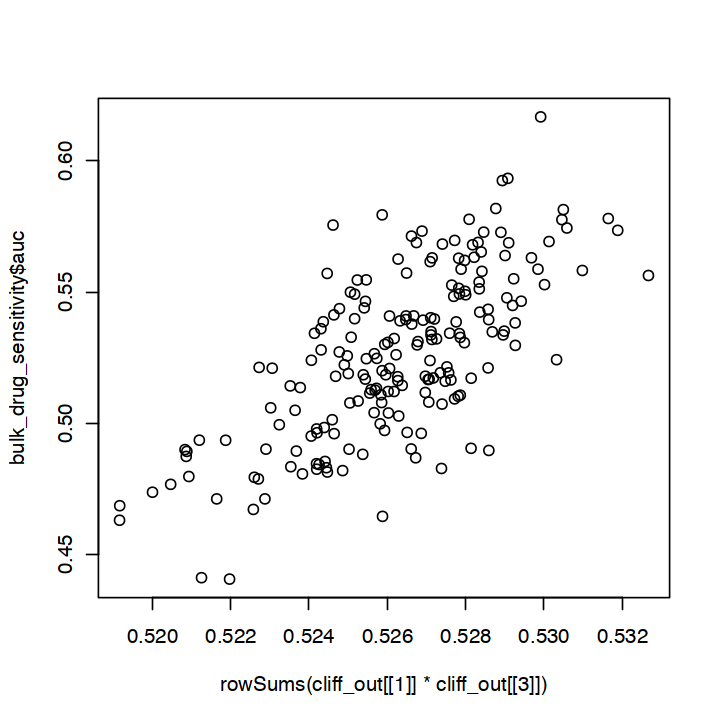

In [163]:
# PCC at bulk level
options(repr.plot.width = 6, repr.plot.height = 6)
rmse(rowSums(cliff_out[[1]] * cliff_out[[3]]), bulk_drug_sensitivity$auc)
cor(rowSums(cliff_out[[1]] * cliff_out[[3]]), bulk_drug_sensitivity$auc)
plot(rowSums(cliff_out[[1]] * cliff_out[[3]]), bulk_drug_sensitivity$auc)

In [164]:
celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
pred_celltype_sensitivity = colMeans(cliff_out[[1]])
cliff_highres = cliff_out[[1]]
colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)

[1] 0.654386

[1] 0.223231

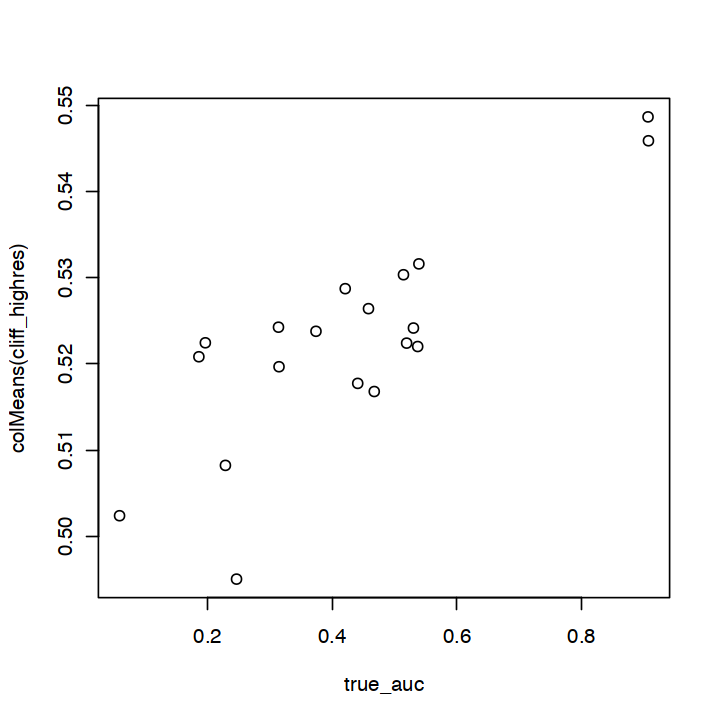

In [165]:
## PCC at cell-type level
options(repr.plot.width = 6, repr.plot.height = 6)

cor_cliff_overall = cor(true_auc, colMeans(cliff_highres), method = 'spearman')
cor_cliff_overall
rmse_cliff_overall = rmse(true_auc, colMeans(cliff_highres))
rmse_cliff_overall

plot(true_auc, colMeans(cliff_highres))

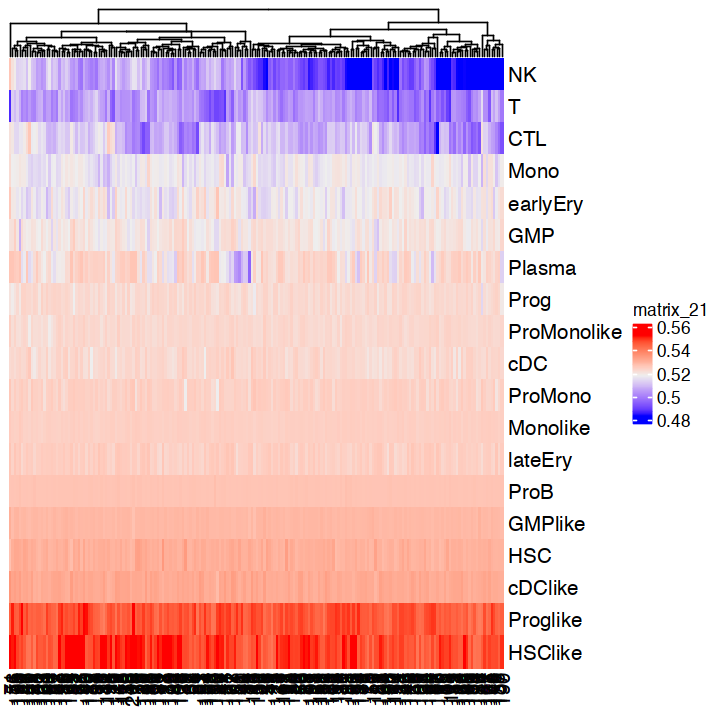

In [166]:
Heatmap(t(cliff_highres[,order(colMeans(cliff_highres))]), cluster_rows = F)

In [167]:
sum(cliff_highres[,order(colMeans(cliff_highres))])

[1] 1986.292

## CLIFF in high-resolution mode

In [168]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=50)
        
# Subset CLIMB output
climb_res.filt = climb_out
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

In [169]:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres', regularization='L2')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5



In [170]:
celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
pred_celltype_sensitivity = colMeans(cliff_out[[1]])
cliff_highres = cliff_out[[1]]
colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)

[1] 0.2334514

[1] 0.8328821

[1] 0.2334514

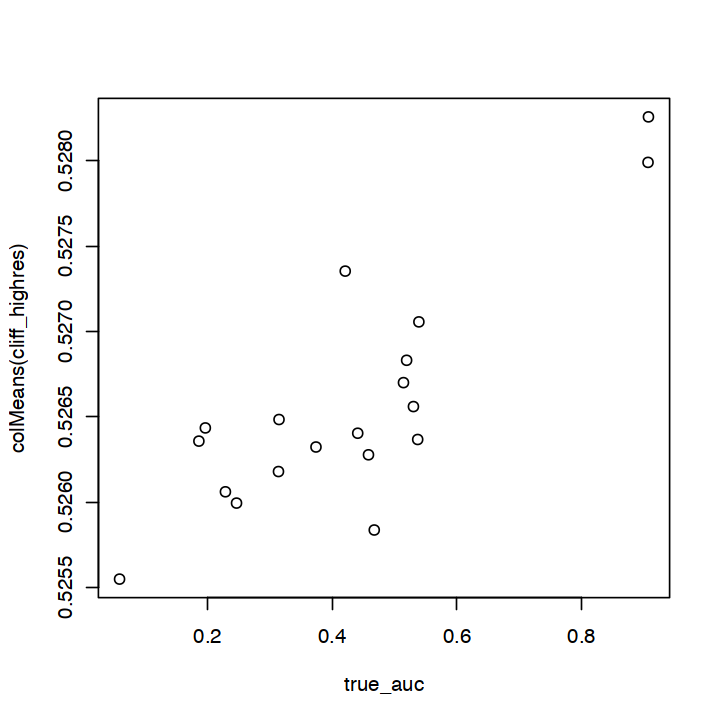

In [171]:
## PCC at cell-type level
rmse(true_auc, colMeans(cliff_highres))
cor_cliff_highres = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
cor_cliff_highres
rmse_cliff_highres = rmse(true_auc, colMeans(cliff_highres))
rmse_cliff_highres

options(repr.plot.width = 6, repr.plot.height = 6)
plot(true_auc, colMeans(cliff_highres))

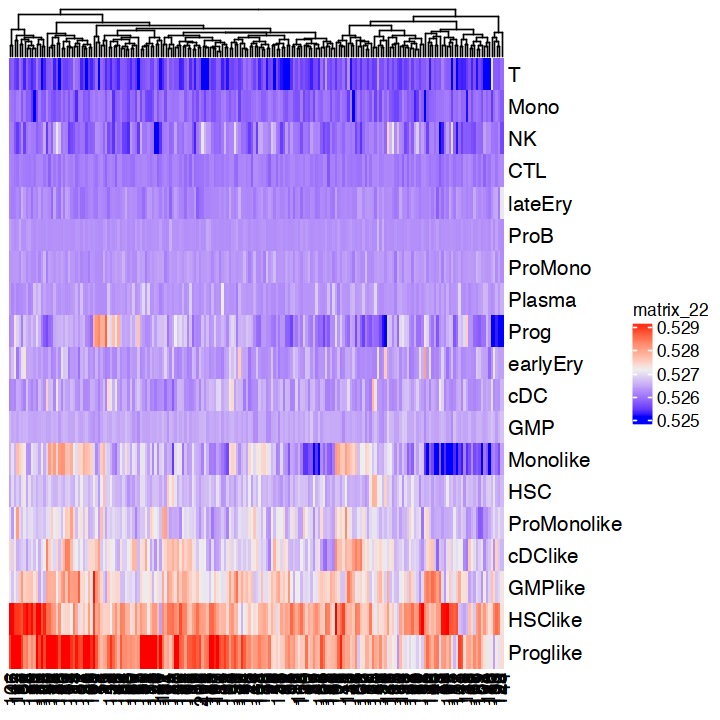

In [172]:
Heatmap(t(cliff_highres[,order(colMeans(cliff_highres))]), cluster_rows=F)

## Positive control: CLIFF with true proportions and true expression

In [89]:
true_expression = readRDS('data/simulation_aml/sim200_celltype_expression.RDS')

In [90]:
dimnames(true_expression)[[1]] = 1:200 
dimnames(true_expression)[[2]] = rownames(bulk.es)
dimnames(true_expression)[[3]] = colnames(pData(bulk.es))

In [91]:
true_proportions = read.csv('data/simulation_aml/simulated_prop.csv', row.names='X')

In [92]:
climb_true = climb_out
climb_true$expr.highres = true_expression
climb_true$props = as.matrix(true_proportions)

In [93]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=500)
        
# Subset CLIMB output
climb_res.filt = climb_true
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = colMeans(climb_res.filt$expr.highres[,sel.genes,], dim=1)

In [94]:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 8



In [95]:
celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
pred_celltype_sensitivity = colMeans(cliff_out[[1]])
cliff_highres = cliff_out[[1]]
colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)

[1] 0.9457588

[1] 0.2325502

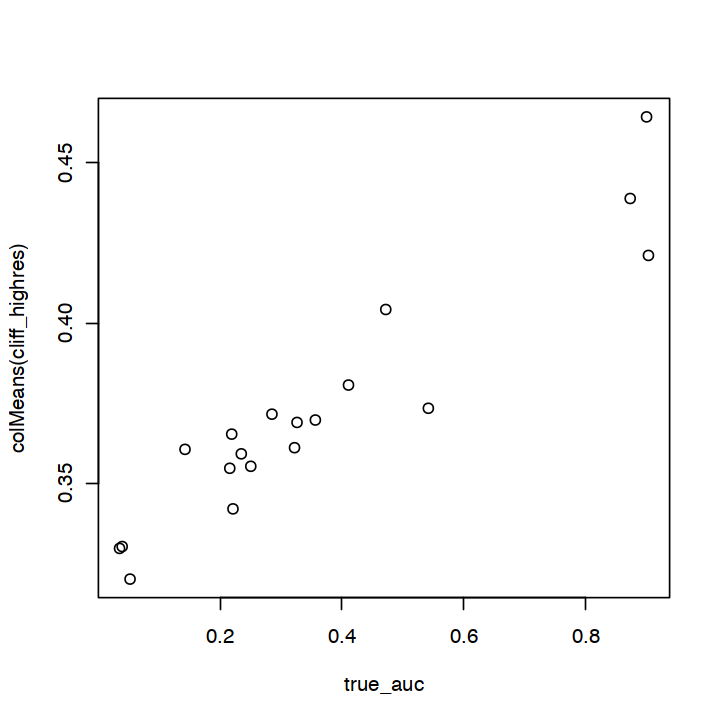

In [96]:
## PCC at cell-type level
options(repr.plot.width = 6, repr.plot.height = 6)

cor_cliff_overall = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
cor_cliff_overall
rmse_cliff_overall = rmse(true_auc, colMeans(cliff_highres))
rmse_cliff_overall

plot(true_auc, colMeans(cliff_highres))

## Linear regression with MuSiC proportions

In [102]:
all_coefs_linreg = coef(glmnet(all_props$MuSiC, bulk_drug_sensitivity$auc, 
                               lambda=0, lower.limit=0, upper.limit=1))
coef_linreg = all_coefs_linreg[-1,dim(all_coefs_linreg)[2]]

cor_karak = cor(celltype_sensitivity_auc$auc, coef_linreg)
cor_karak
rmse_karak = rmse(true_auc, coef_linreg)
rmse_karak

[1] 0.7362135

[1] 0.207404

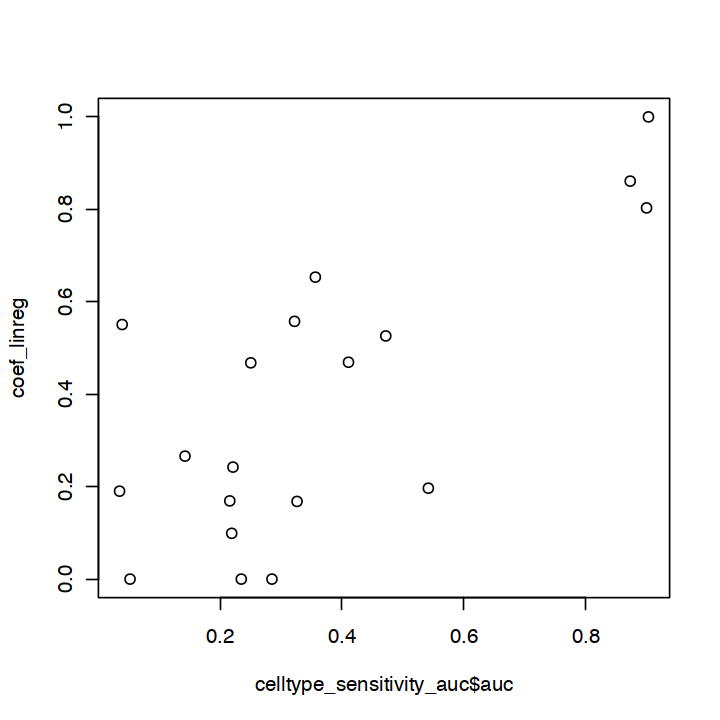

In [103]:
plot(celltype_sensitivity_auc$auc, coef_linreg)

## Zeng approach:  correlation between CiberSortX props and drug sensitivity AUC

In [200]:
zeng_cor = cor(all_props$CiberSortX, bulk_drug_sensitivity$auc)
cor(celltype_sensitivity_auc$auc, zeng_cor)
rmse(celltype_sensitivity_auc$auc, zeng_cor)

0.7986365


[1] 0.4461937

## Bottomly et al. approach: PC1 made from Van Galen signatures

We use Van Galen signatures for the 6 cancer cell-types and define signatures for the other cell-type with Seurat `FindMarkers`. 

In [109]:
library(Seurat)
sc.srt <- CreateSeuratObject(counts = exprs(sc.es), project = "vg", min.cells = 3, min.features = 200)
Idents(object = sc.srt) <- sc.es$cellType
sc.srt <- NormalizeData(sc.srt)
sc.srt <- FindVariableFeatures(sc.srt, selection.method = "vst", nfeatures = 2000)
sc.srt <- ScaleData(sc.srt)

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Centering and scaling data matrix



In [110]:
celltype_names = as.character(unique(sc.es$cellType))
celltype_names = celltype_names[!grepl('like',celltype_names)]
markers_l = list() ; markers_top50_l = list()
for(k in 1:length(celltype_names)){
    this_celltype = celltype_names[k]
    message(this_celltype)
    markers_l[[k]] = FindMarkers(sc.srt, ident.1=this_celltype)
    markers_top50_l[[k]] = rownames(head(markers_l[[k]], 50))
}
celltype_markers = unique(do.call(c,markers_top50_l))

GMP

Mono

Prog

cDC

HSC

ProMono

earlyEry

CTL

T

Plasma

ProB

NK

lateEry



In [111]:
marker_genes = do.call(cbind,markers_top50_l)
colnames(marker_genes) = celltype_names

In [112]:
vangalen_sign = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')

In [113]:
colnames(vangalen_sign) = gsub('\\.','',colnames(vangalen_sign))

In [114]:
all_marker_genes = cbind(vangalen_sign, marker_genes)
colnames(all_marker_genes) = gsub('Monocytelike', 'Monolike', gsub('Promonolike', 'ProMonolike', gsub('Progenitorlike', 'Proglike', colnames(all_marker_genes))))

In [115]:
all(colnames(all_marker_genes) %in% colnames(pData(bulk.es)))

[1] TRUE

In [116]:
all_marker_genes_ = all_marker_genes[1:10,]

In [117]:
all_celltypes = colnames(all_marker_genes_)
cor_per_celltype = list()
for(k in 1:length(all_celltypes)){
    this_celltype = all_celltypes[k]
    bulk_expr_ct = exprs(bulk.es)[rownames(bulk.es) %in% all_marker_genes_[,k],]
    bulk_logcpm_ct = log2(1e6*t(t(bulk_expr_ct) / colSums(bulk_expr_ct))+1)
    colsums = colSums(bulk_logcpm_ct)
    prcomp.out = prcomp(t(bulk_logcpm_ct))
    pc1_ct = prcomp.out$x[,1]
    # if it positively correlated, we keep it as it is. Otherwise, we inverse the sign
    if( cor(pc1_ct, colsums) < 0 ){
        pc1_ct = pc1_ct*-1
    }
    #cor_per_celltype[[k]] = cor(pc1_ct, drug_sensitivity_auc$auc)
}

In [118]:
options(repr.plot.width = 6, repr.plot.height = 6)
#plot(num(cor_per_celltype), num(celltype_sensitivity_auc[all_celltypes,]$auc))

In [121]:
all_celltypes = colnames(all_marker_genes_)
all_pc1s = list()
for(k in 1:length(all_celltypes)){
    this_celltype = all_celltypes[k]
    bulk_expr_ct = exprs(bulk.es)[rownames(bulk.es) %in% all_marker_genes_[,k],]
    bulk_logcpm_ct = log2(1e6*t(t(bulk_expr_ct) / colSums(bulk_expr_ct))+1)
    colsums = colSums(bulk_logcpm_ct)
    prcomp.out = prcomp(t(bulk_logcpm_ct))
    pc1_ct = prcomp.out$x[,1]
    # if it positively correlated, we keep it as it is. Otherwise, we inverse the sign
    if( cor(pc1_ct, colsums) < 0 ){
        pc1_ct = pc1_ct*-1
    }
    all_pc1s[[k]] = pc1_ct
}

In [122]:
all_PC1s = do.call(cbind,all_pc1s)
colnames(all_PC1s) = all_celltypes
#all_PC1s = all_PC1s[,celltype_sensitivity_auc$sample]

In [123]:
colnames(climb_prop) = reformat_celltypes(colnames(climb_prop))

In [124]:
all_PC1s = all_PC1s[,colnames(climb_prop)]

## Generate 10 simulations 

These ten simulations are stored in RDS object and can be directly loaded on next cell!

In [15]:
climb_prop = climb_out$props 
true_proportions = pData(bulk.es)
all_celltype_auc = list() ; all_bulk_auc = list()
for(i in 1:10){ # 10 different simulations
    # Generate cell-type drug sensitivity
    out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[i]], 
                                               high_decay = list_high_decays[[i]], climb_prop)
    celltype_sensitivity = out_1[[1]]
    celltype_sensitivity_auc = out_1[[2]]
    all_celltype_auc[[i]] = celltype_sensitivity_auc
    
    # Generate bulk drug sensitivity
    bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
    bulk_drug_sensitivity_raw = bulk_out_[[1]]
    bulk_drug_sensitivity = bulk_out_[[2]]
    all_bulk_auc[[i]] = bulk_drug_sensitivity
}

celltype_auc = do.call(cbind,all_celltype_auc)
celltype_auc = celltype_auc[,grepl('auc', colnames(celltype_auc))]

colnames(celltype_auc) = paste0('simulation_', 1:10)

celltype_auc = t(celltype_auc)

options(repr.plot.width = 6, repr.plot.height = 4)
h <- Heatmap(celltype_auc, show_column_dend = F, name='AUC')
row_ord = row_order(h)
#pdf('results/fig5/heatmap_10simulation_celltype_auc.pdf', width=6, height=4) ; h ; dev.off()
h

bulk_auc = do.call(cbind,all_bulk_auc)
bulk_auc = bulk_auc[,grepl('auc', colnames(bulk_auc))]

bulk_auc = t(bulk_auc)
rownames(bulk_auc) = paste0('simulation_', 1:10)

options(repr.plot.width = 8, repr.plot.height = 3)
h <- Heatmap(bulk_auc, show_column_dend = F, show_column_names = F,  name='AUC')
#pdf('results/fig5/heatmap_10simulation_bulk_auc.pdf', width=8, height=3) ; h ; dev.off()
h

saveRDS(celltype_auc, 'results/fig5/celltype_auc.RDS')
saveRDS(bulk_auc, 'results/fig5/bulk_auc.RDS')

## Run 10 simulations and perform deconvolution with different methods

In [173]:
cibersortx_prop = all_props$CiberSortX
cibersortx_prop = cibersortx_prop + randn(nrow=dim(cibersortx_prop)[1], ncol=dim(cibersortx_prop)[2], 
                                         mean=0, sd=0.05)
cibersortx_prop = cibersortx_prop / rowSums(cibersortx_prop)
rowSums(cibersortx_prop)

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 
181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 
  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1

In [106]:
celltype_auc = readRDS('results/fig5/celltype_auc.RDS')
bulk_auc = readRDS('results/fig5/bulk_auc.RDS')

In [209]:
climb_prop = climb_out$props
rownames(climb_prop) = 1:200
cor_cliff_overall_l = list() ; rmse_cliff_overall_l = list()
cor_cliff_highres_l = list() ; rmse_cliff_highres_l = list()
cor_linreg_l = list() ; rmse_linreg_l = list()
cor_bottomly_l = list() ; rmse_bottomly_l = list()
cor_zeng_l =list() ; rmse_zeng_l = list()
all_true_auc = list() ; all_cliff_overall_auc = list()
for(i in 1:10){ # 10 different simulations
    # Generate cell-type drug sensitivity
    true_auc = celltype_auc[i,]
    celltype_sensitivity_auc = data.frame(sample=colnames(celltype_auc), auc=num(celltype_auc[i,]))
    rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample 
    
    # Generate bulk drug sensitivity
    drug_data = bulk_auc[i,]
    bulk_drug_sensitivity = data.frame(sample=as.character(1:200), auc=num(drug_data))
    
    # Feature Selection 
    bulk_mat = t(exprs(bulk.es))
    #drug_data = bulk_drug_sensitivity$auc
    sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=50)
    # Subset CLIMB output
    climb_res.filt = climb_out
    climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
    climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
    
    # Run CLIFF-overall:
    cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')
    celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
    rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
    pred_celltype_sensitivity = colMeans(cliff_out[[1]])
    cliff_highres = cliff_out[[1]]
    colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
    cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
    true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
    cor_cliff_overall_l[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
    message(paste0('CLIFF-overall PCC: ', cor_cliff_overall_l[[i]]))
    rmse_cliff_overall_l[[i]] = rmse(true_auc, colMeans(cliff_highres))
    all_true_auc[[i]] = true_auc
    all_cliff_overall_auc[[i]] = colMeans(cliff_highres)    
    
    # Feature Selection 
    bulk_mat = t(exprs(bulk.es))
    #drug_data = bulk_drug_sensitivity$auc
    sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=50)
    # Subset CLIMB output
    climb_res.filt = climb_out
    climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
    climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
    
    # Run CLIFF-highres
    cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres', regularization='L2')
    celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
    rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
    pred_celltype_sensitivity = colMeans(cliff_out[[1]])
    cliff_highres = cliff_out[[1]]
    colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
    cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
    true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
    cor_cliff_highres_l[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
    message(paste0('CLIFF-highres PCC: ', cor_cliff_highres_l[[i]]))
    rmse_cliff_highres_l[[i]] = rmse(true_auc, colMeans(cliff_highres))
    
    # Run linreg (Linear Regression with CLIMB props):
    all_coefs_linreg = coef(glmnet(all_props$CLIMB, bulk_drug_sensitivity$auc))
    coef_linreg = all_coefs_linreg[-1,dim(all_coefs_linreg)[2]]
    cor_linreg_l[[i]] = cor(celltype_sensitivity_auc$auc, coef_linreg)
    message(paste0('linreg PCC: ', cor_linreg_l[[i]]))
    rmse_linreg_l[[i]] = rmse(true_auc, coef_linreg)
    
    # Run Bottomly approach (PC1 from van galen signatures - requires to load van galen signatures):
    bottomly_ct_drug_sens = cor(all_PC1s, bulk_drug_sensitivity$auc)
    cor_bottomly_l[[i]] = cor(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)
    message(paste0('Bottomly PCC: ', cor_bottomly_l[[i]]))
    rmse_bottomly_l[[i]] = rmse(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)
    
    # Run Zeng approach (PCC between CiberSortX proportions and drug sensitivity AUC):
    zeng_cor = cor(all_props$CiberSortX, bulk_drug_sensitivity$auc)
    cor_zeng_l[[i]] = num(cor(zeng_cor, celltype_sensitivity_auc$auc))
    rmse_zeng_l[[i]] = rmse(zeng_cor, celltype_sensitivity_auc$auc)
    message(paste0('Zeng PCC: ', cor_zeng_l[[i]]))
}

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.814060409552771

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.664013387569545

linreg PCC: 0.651669014690174

Bottomly PCC: 0.597980372319563

Zeng PCC: 0.17062210789916

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM a

In [210]:
all_cors = do.call(cbind, list(cor_cliff_overall_l, cor_cliff_highres_l, cor_linreg_l, cor_bottomly_l, cor_zeng_l))
all_cors = data.frame(t(apply(all_cors, 1, num)))

No id variables; using all as measure variables



pdf 
  2

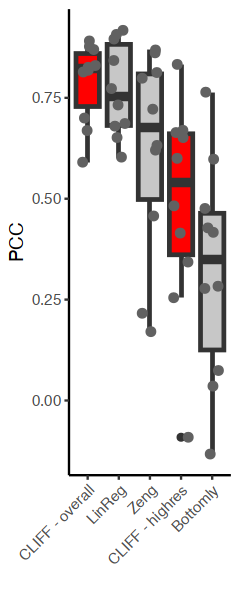

In [212]:
colnames(all_cors) = c('CLIFF - overall', 'CLIFF - highres', 'LinReg', 'Bottomly', 'Zeng')
rownames(all_cors) = 1:10
melt_cors = melt(all_cors)
colnames(melt_cors) = c('method', 'PCC')
order_levels = order(aggregate(melt_cors$PCC, list(melt_cors$method), median)$x)
melt_cors$method = factor(melt_cors$method, levels=levels(melt_cors$method)[rev(order_levels)])
options(repr.plot.width = 2, repr.plot.height = 5)
g <- ggplot(melt_cors, aes(x=method, y=PCC, fill=method)) + geom_boxplot(size=1) + 
    geom_jitter(size=2, color='grey38',width=0.25, height=0) +theme_classic() +
    scale_fill_manual(values = ifelse(grepl('CLIFF', levels(melt_cors$method)), 'red', 'grey78'))+
    scale_color_manual(values = ifelse(grepl('CLIFF', levels(melt_cors$method)), 'red', 'grey78'))+
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('') #+ ylim(c(0,1.0))
pdf('results/fig5/boxplot_cliff_vs_others_10drugs_sim.pdf', width=2, height=5) ; g ; dev.off()
g

In [214]:
aggregate(melt_cors$PCC, list(melt_cors$method), median)

Group.1,x
<fct>,<dbl>
CLIFF - overall,0.8219504
LinReg,0.7526850
Zeng,0.6770096
CLIFF - highres,0.5412114
Bottomly,0.3499762


No id variables; using all as measure variables



pdf 
  2

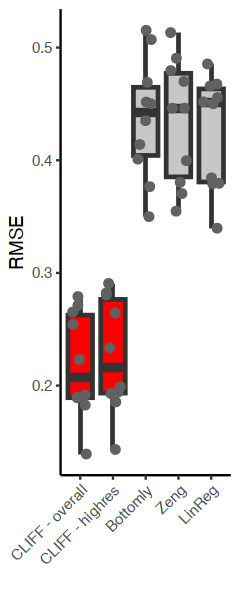

In [216]:
all_rmses = do.call(cbind, list(rmse_cliff_overall_l, rmse_cliff_highres_l, rmse_linreg_l, rmse_bottomly_l, rmse_zeng_l))
all_rmses = data.frame(t(apply(all_rmses, 1, num)))
colnames(all_rmses) = c('CLIFF - overall', 'CLIFF - highres', 'LinReg', 'Bottomly', 'Zeng')
rownames(all_rmses) = 1:10
melt_rmses = melt(all_rmses)
colnames(melt_rmses) = c('method', 'RMSE')
order_levels = order(aggregate(melt_rmses$RMSE, list(melt_rmses$method), median)$x)
melt_rmses$method = factor(melt_rmses$method, levels=levels(melt_rmses$method)[order_levels])
options(repr.plot.width = 2, repr.plot.height = 5)
g <- ggplot(melt_rmses, aes(x=method, y=RMSE, fill=method)) + geom_boxplot(size=1) + 
    geom_jitter(size=2, color='grey38',width=0.25, height=0) +theme_classic() +
    scale_fill_manual(values = ifelse(grepl('CLIFF', levels(melt_rmses$method)), 'red', 'grey78'))+
    scale_color_manual(values = ifelse(grepl('CLIFF', levels(melt_rmses$method)), 'red', 'grey78'))+
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('')
pdf('results/fig5/boxplot_cliff_vs_others_10drugs_sim_RMSE.pdf', width=2, height=5) ; g ; dev.off()
g

In [217]:
aggregate(melt_rmses$RMSE, list(melt_rmses$method), median)

Group.1,x
<fct>,<dbl>
CLIFF - overall,0.2074249
CLIFF - highres,0.2161682
Bottomly,0.4426787
Zeng,0.4462211
LinReg,0.4510363


In [218]:
cliff_overall_auc_mat = do.call(rbind, all_cliff_overall_auc)
rownames(cliff_overall_auc_mat) = rownames(celltype_auc)
colnames(cliff_overall_auc_mat) = colnames(celltype_auc)

## Simulation with mutation and bulk-level variability

In [219]:
generate_celltype_drug_sensitivity_highres <- function(low_decay = c('Monolike', 'Mono', 'ProMonolike'),
                                               high_decay = c('HSC', 'HSClike', 'Prog', 'Proglike'),
                                               props, signal_to_noise_ratio = 20){
    sample_names = rownames(props)
    list_results = list()
    for(n in 1:length(sample_names)){
        message(n)
        celltypes = colnames(props)
        celltype_sensitivity = matrix(0,length(celltypes),7)
        decays = list()
        for(k in 1:length(celltypes)){
            ct = celltypes[k]
            if(ct %in% low_decay){
                #set.seed(k)
                decays[[k]] = runif(1,0.7,1.0)
            } else if(ct %in% high_decay) {
                #set.seed(k)
                decays[[k]] = runif(1,6.0,8.0)
            } else  {
                decays[[k]] = runif(1,1.2,2.2)
            }

            for(d in 1:7){
                celltype_sensitivity[k,d] = 1/(1 + exp(decays[[k]]*d - 8))
            }
        }
        decays = num(decays)
        ### Add random noise
        Signal = celltype_sensitivity
        Noise = randn(nrow(celltype_sensitivity),ncol(celltype_sensitivity))
        Signal_Power = sum(abs(Signal)*abs(Signal))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
        Noise_Power = sum(abs(Noise)*abs(Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
        Initial_SNR = 10*(log10(Signal_Power/Noise_Power));
        K = (Signal_Power/Noise_Power)*10^(-signal_to_noise_ratio/10)
        New_Noise = sqrt(K)*Noise
        New_Noise_Power = sum(abs(New_Noise)*abs(New_Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity))
        New_SNR = 10*(log10(Signal_Power/New_Noise_Power))
        Noisy_Signal = Signal + New_Noise;
        Noisy_Signal[Noisy_Signal < 0.0] = 0.0
        Noisy_Signal[Noisy_Signal > 1.0] = 1.0
        ## Reformat and returnk
        celltype_sensitivity = Noisy_Signal
        rownames(celltype_sensitivity) = celltypes
        colnames(celltype_sensitivity) = c(1:7)
        celltype_sensitivity = data.frame(celltype_sensitivity)
        celltype_sensitivity$sample = rownames(celltype_sensitivity)
        colnames(celltype_sensitivity) = gsub('X', 'd', colnames(celltype_sensitivity))
        melt_celltype_sensitivity = melt(celltype_sensitivity)
        celltype_sensitivity_auc = aggregate(melt_celltype_sensitivity$value, list(melt_celltype_sensitivity$sample), computeAUC_)
        colnames(celltype_sensitivity_auc) = c('sample', 'auc')
        rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample
        list_results[[n]] = list(as.matrix(celltype_sensitivity[,-8]),celltype_sensitivity_auc)
    }
    return(list_results)
}

generate_bulk_drug_sensitivity_highres <- function(celltype_ds, props){
    all_patients = rownames(props)
    celltypes = colnames(props)
    bulk_survivals = list()
    tab_ct = props*5000
    set.seed(1)
    for(n in 1:length(all_patients)){
        this_patient = rownames(props)[n]
        celltype_sensitivity_1p = matrix(0,length(celltypes),7)
        tab_ct_1p = tab_ct[n,]
        counts  = tab_ct[n,]
        for(k in 1:length(celltypes)){
            counts_k  = counts[k]
            for(d in 1:7){
                celltype_sensitivity_1p[k,d] = num(round(counts_k*celltype_ds[[n]][[1]][k,d]))
            }
        }
        rownames(celltype_sensitivity_1p) = celltypes
        colnames(celltype_sensitivity_1p) = c(1:7)
        celltype_sensitivity_1p_n = apply(celltype_sensitivity_1p, 2, function(x) x/tab_ct_1p)
        celltype_sensitivity_1p_n[is.na(celltype_sensitivity_1p_n)] <- 0
        bulk_sensitivity = colSums(celltype_sensitivity_1p) / sum(tab_ct_1p)
        bulk_survivals[[n]] = bulk_sensitivity
    }
    bulk_drug_sensitivity = do.call(rbind, bulk_survivals)
    rownames(bulk_drug_sensitivity) = all_patients
    bulk_drug_sensitivity = data.frame(bulk_drug_sensitivity)
    bulk_drug_sensitivity$sample = rownames(bulk_drug_sensitivity)
    colnames(bulk_drug_sensitivity) = gsub('X', 'd', colnames(bulk_drug_sensitivity))
    melt_drug_sensitivity_data = melt(bulk_drug_sensitivity)                                    
    drug_sensitivity_auc = aggregate(melt_drug_sensitivity_data$value, list(melt_drug_sensitivity_data$sample), computeAUC_)
    colnames(drug_sensitivity_auc) = c('sample', 'auc')
    rownames(drug_sensitivity_auc) = drug_sensitivity_auc$sample
    drug_sensitivity_auc = drug_sensitivity_auc[order(num(drug_sensitivity_auc$sample)),]
    return(list(bulk_drug_sensitivity, drug_sensitivity_auc))
}
## Parameters to build 10 simulations:
list_low_decays = list(c('Monolike', 'Mono', 'ProMonolike'), c('HSClike', 'HSC', 'Proglik', 'Prog'),
                       c('GMP', 'GMPlike'), c('cDC-like', 'cDC'), c('HSC-like'), c('Monolike'), 
                       c('T'), c('HSC'), c('Proglike', 'Prog'), c('ProMonolike', 'T', 'GMP'))
list_high_decays = list(c('HSClike', 'HSC', 'Proglik', 'Prog'), c('Monolike', 'Mono', 'ProMonolike'), 
                       c('cDC-like', 'cDC'), c('HSC-like'), c('GMP', 'GMPlike'), c('HSC'),
                        c('Proglike', 'HSClike'), c('T'), c('T','CTL', 'GMP'), c('HSC','HSClike','Proglike'))

In [313]:
 # Generate cell-type drug sensitivity
out_1 = generate_celltype_drug_sensitivity_highres(high_decay = list('Monolike', 'ProMonolike'), 
                                                   low_decay = list('HSClike', 'Proglike'),
                                                   true_proportions[1:100,])

1

Using sample as id variables

2

Using sample as id variables

3

Using sample as id variables

4

Using sample as id variables

5

Using sample as id variables

6

Using sample as id variables

7

Using sample as id variables

8

Using sample as id variables

9

Using sample as id variables

10

Using sample as id variables

11

Using sample as id variables

12

Using sample as id variables

13

Using sample as id variables

14

Using sample as id variables

15

Using sample as id variables

16

Using sample as id variables

17

Using sample as id variables

18

Using sample as id variables

19

Using sample as id variables

20

Using sample as id variables

21

Using sample as id variables

22

Using sample as id variables

23

Using sample as id variables

24

Using sample as id variables

25

Using sample as id variables

26

Using sample as id variables

27

Using sample as id variables

28

Using sample as id variables

29

Using sample as id variables

30

Using sample as id 

In [314]:
celltype_auc_sensitive = do.call(rbind, lapply(out_1, function(x) x[[2]]$auc))
colnames(celltype_auc_sensitive) = colnames(true_proportions)
rownames(celltype_auc_sensitive) = 1:100                                          

In [315]:
# Generate bulk drug sensitivity
bulk_out_sensitive = generate_bulk_drug_sensitivity_highres(out_1, true_proportions[1:100,])
bulk_out_sensitive = bulk_out_sensitive[[2]]

Using sample as id variables



In [316]:
 # Generate cell-type drug sensitivity
out_2 = generate_celltype_drug_sensitivity_highres(low_decay = list('Monolike', 'ProMonolike'), 
                                                   high_decay = list('HSClike', 'Proglike'),
                                                   true_proportions[101:200,])

1

Using sample as id variables

2

Using sample as id variables

3

Using sample as id variables

4

Using sample as id variables

5

Using sample as id variables

6

Using sample as id variables

7

Using sample as id variables

8

Using sample as id variables

9

Using sample as id variables

10

Using sample as id variables

11

Using sample as id variables

12

Using sample as id variables

13

Using sample as id variables

14

Using sample as id variables

15

Using sample as id variables

16

Using sample as id variables

17

Using sample as id variables

18

Using sample as id variables

19

Using sample as id variables

20

Using sample as id variables

21

Using sample as id variables

22

Using sample as id variables

23

Using sample as id variables

24

Using sample as id variables

25

Using sample as id variables

26

Using sample as id variables

27

Using sample as id variables

28

Using sample as id variables

29

Using sample as id variables

30

Using sample as id 

In [317]:
celltype_auc_resistant = do.call(rbind, lapply(out_2, function(x) x[[2]]$auc))
colnames(celltype_auc_resistant) = colnames(true_proportions)
rownames(celltype_auc_resistant) = 101:200                                          

In [318]:
# Generate bulk drug sensitivity
bulk_out_resistant = generate_bulk_drug_sensitivity_highres(out_2, true_proportions[101:200,])
bulk_out_resistant = bulk_out_resistant[[2]]

Using sample as id variables



In [319]:
mat_true_highres = t(rbind(celltype_auc_sensitive,celltype_auc_resistant))

In [320]:
mat_true_highres = data.frame(mat_true_highres)
rownames(mat_true_highres) = colnames(celltype_auc_resistant)
colnames(mat_true_highres) = 1:200

In [321]:
quant = quantile(flatten(t(mat_true_highres)), probs=c(0,0.05,0.5,0.95,1))# ; quant[3] = 0.5
col_fun = colorRamp2(c(quant[1], quant[2], quant[3], quant[4], quant[5]), rev(c("darkred", "red", "white", "cornflowerblue", "darkblue")))

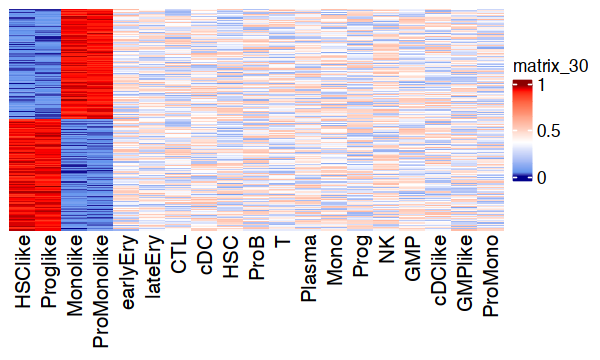

In [322]:
options(repr.plot.width = 5, repr.plot.height = 3)
h <- Heatmap(t(mat_true_highres), cluster_rows=F, show_row_names = F, show_column_dend = F,
            col=col_fun)
h <- draw(h)
row_ord = row_order(h)
col_ord = column_order(h)
#pdf('results/fig5/heatmap_highres_expression_200sim_true.pdf', width=5, height=3) ; h ; dev.off()
h

In [323]:
# We generate simulated mutation data that followed the two groups
set.seed(1)
mut.data = cbind(c(rbinom(100, 1, 0.8), rep(0,100)), c(rbinom(100, 1, 0.8), rep(0,100)),
                 c(rep(0,100), rbinom(100, 1, 0.8)), c(rep(0,100), rbinom(100, 1, 0.8)),
                 c(rbinom(100, 1, 0.4), rep(0,100)), c(rbinom(100, 1, 0.4), rep(0,100)),
                 c(rep(0,100), rbinom(100, 1, 0.4)), c(rep(0,100), rbinom(100, 1, 0.4)),
                 rbinom(200, 1, 0.4), rbinom(200, 1, 0.6))
mut.data = data.frame(mut.data)
rownames(mut.data) = 1:200
colnames(mut.data) = gsub('X', 'mut', colnames(mut.data))

In [324]:
col_fun = colorRamp2(breaks=c(0,1), colors=c("white", "grey38"))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


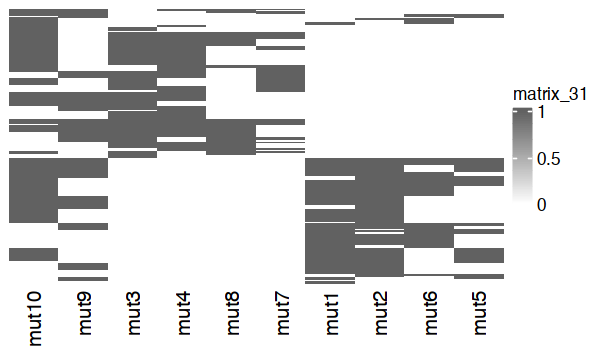

In [325]:
options(repr.plot.width = 5, repr.plot.height = 3)
h <- Heatmap(mut.data, show_row_names = F, show_column_dend = F, show_row_dend = F, col=col_fun)
#pdf('results/fig5/heatmap_highres_expression_200sim_mutation.pdf', width=5, height=3) ; h ; dev.off()
h

In [326]:
bulk_drug_sensitivity = rbind(bulk_out_sensitive, bulk_out_resistant)

In [332]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
#drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, bulk_drug_sensitivity$auc, min.genes=50)
# Subset CLIMB output
climb_res.filt = climb_out
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

In [337]:
# Run CLIFF-highres:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, mut.data, max.em.steps=200, mode = 'highres', regularization='L2')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 10



In [338]:
cliff_highres = cliff_out[[1]]

In [339]:
quant = quantile(flatten(cliff_highres), probs=c(0,0.05,0.5,0.95,1))# ; quant[3] = 0.5
col_fun = colorRamp2(c(quant[1], quant[2], quant[3], quant[4], quant[5]), rev(c("darkred", "red", "white", "cornflowerblue", "darkblue")))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

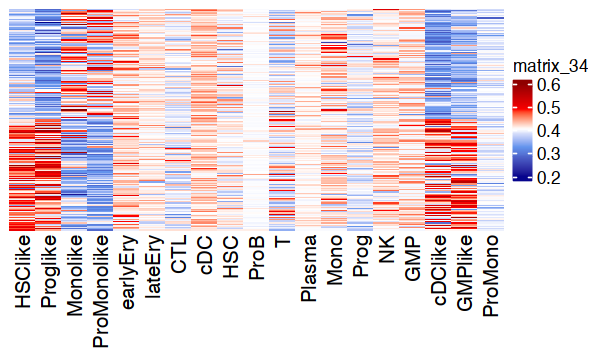

In [340]:
options(repr.plot.width = 5, repr.plot.height = 3)

h<- Heatmap(cliff_highres[row_ord, col_ord], cluster_columns=F, cluster_rows = F, show_row_names = F, 
            show_column_dend = F, col=col_fun)
pdf('results/fig5/heatmap_highres_expression_200sim_cliff_highres_FINAL.pdf', width=5, height=3) ; h ; dev.off()
h

## Compare different number of genes as input

How many genes should be given as input for CLIFF ? 

In [349]:
climb_prop = climb_out$props
rownames(climb_prop) = 1:200

# Generate simulated cell-type drug sensitivity
out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[1]], 
                                           high_decay = list_high_decays[[1]], climb_prop)
celltype_sensitivity = out_1[[1]]
celltype_sensitivity_auc = out_1[[2]]

# Generate bulk drug sensitivity
bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
bulk_drug_sensitivity_raw = bulk_out_[[1]]
bulk_drug_sensitivity = bulk_out_[[2]]

Using sample as id variables

Using sample as id variables



In [113]:
min.n.genes_vec = c(1,10,25,50,100,200,500,1000)
pcc_overall_l = list() ; rmse_overall_l = list() ; n_genes = list()
pcc_highres_l = list() ; rmse_highres_l = list() ; 
pcc_overall_l2_l = list() ; rmse_overall_l2_l = list()
pcc_highres_l2_l = list() ; rmse_highres_l2_l = list() ;

for(x in 1:10){ # 10 different simulations
    # Generate cell-type drug sensitivity
    out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[x]], 
                                               high_decay = list_high_decays[[x]], climb_prop)
    celltype_sensitivity = out_1[[1]]
    celltype_sensitivity_auc = out_1[[2]]

    # Generate bulk drug sensitivity
    bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
    bulk_drug_sensitivity_raw = bulk_out_[[1]]
    bulk_drug_sensitivity = bulk_out_[[2]]
    
    pcc_overall = list() ; rmse_overall = list() ; 
    pcc_highres = list() ; rmse_highres = list() ; 
    pcc_overall_l2 = list() ; rmse_overall_l2 = list() ; 
    pcc_highres_l2 = list() ; rmse_highres_l2 = list() ; 

    for(i in 1:length(min.n.genes_vec)){
        n.genes = min.n.genes_vec[i]
        message(paste0('n_genes: ', n.genes))
        n_genes[[i]] = length(sel.genes)
        
        # Feature Selection 
        bulk_mat = t(exprs(bulk.es))
        drug_data = bulk_drug_sensitivity$auc
        sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=n.genes)
        
        # Subset CLIMB output
        climb_res.filt = climb_out
        climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
        climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

        # Run CLIFF-overall:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_overall[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-overall PCC: ', pcc_overall[[i]]))
        rmse_overall[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-overall RMSE: ', rmse_overall[[i]]))

        # Run CLIFF-highres
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_highres[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-highres PCC: ', pcc_highres[[i]]))
        rmse_highres[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-highres RMSE: ', rmse_highres[[i]]))
        
        # Run CLIFF-overall with L2 reg:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall', regularization = 'L2')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_overall_l2[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-overall PCC: ', pcc_overall_l2[[i]]))
        rmse_overall_l2[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-overall RMSE: ', rmse_overall_l2[[i]]))

        # Run CLIFF-highres with L2 reg:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres', regularization = 'L2')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_highres_l2[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-highres PCC: ', pcc_highres_l2[[i]]))
        rmse_highres_l2[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-highres RMSE: ', rmse_highres_l2[[i]]))
    }
    pcc_overall_l[[x]] = num(pcc_overall) ;  rmse_overall_l[[x]] = num(rmse_overall) ; 
    pcc_highres_l[[x]] = num(pcc_highres) ;  rmse_highres_l[[x]] = num(rmse_highres) ; 
    pcc_overall_l2_l[[x]] = num(pcc_overall_l2) ;  rmse_overall_l2_l[[x]] = num(rmse_overall_l2) ; 
    pcc_highres_l2_l[[x]] = num(pcc_highres_l2) ;  rmse_highres_l2_l[[x]] = num(rmse_highres_l2) ; 
}

Using sample as id variables

Using sample as id variables

n_genes: 1

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.862921646436714

CLIFF-overall RMSE: 0.260626791943659

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.679460783437149

CLIFF-highres RMSE: 0.270680744433582

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algo

In [385]:
mat_ = data.frame(do.call(rbind,pcc_highres_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_highres = melt(mat_)
melt_highres$method = 'CLIFF-highres'
mat_ = data.frame(do.call(rbind,pcc_highres_l2_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_highres_l2 = melt(mat_)
melt_highres_l2$method = 'CLIFF-highres-L2'
mat_ = data.frame(do.call(rbind,pcc_overall_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_overall = melt(mat_)
melt_overall$method = 'CLIFF-overall'
mat_ = data.frame(do.call(rbind,pcc_overall_l2_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_overall_l2 = melt(mat_)
melt_overall_l2$method = 'CLIFF-overall-L2'

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



In [387]:
melt_ = rbind(melt_highres, melt_highres_l2, melt_overall, melt_overall_l2)

In [394]:
write.csv(melt_, 'data/simulation_aml/cliff_accuracy_vs_n_genes_200sim.csv', quote=F)
melt_ = read.csv('data/simulation_aml/cliff_accuracy_vs_n_genes_200sim.csv', row.names='X')

In [398]:
melt_$variable = factor(melt_$variable, levels=unique(melt_$variable)[order(num(unique(melt_$variable)))])

pdf 
  2

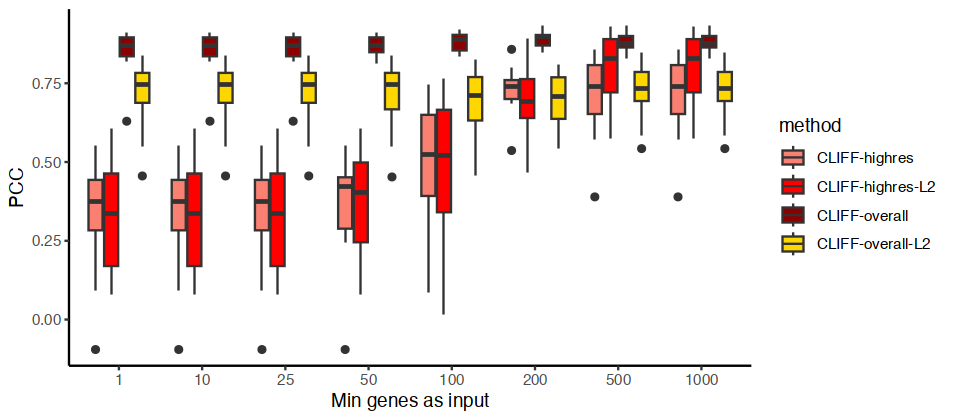

In [400]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
g <- ggplot(melt_) + geom_boxplot(aes(x=variable, y=value, fill=method)) +
    scale_fill_manual(values = c('salmon', 'red', 'darkred', 'gold')) +theme_classic() +
    xlab('Min genes as input') + ylab('PCC')
pdf('results/fig5/boxplot_cliff_accuracy_vs_n_genes_200sim.csv.pdf', width=8, height=3.5) ; g ; dev.off()
g

## Re-run bigger simulation with increasing number of bulk sample as input 

In [280]:
n_bulk_samples = c(5,10,25,50,75,100,150,200) # 10 different sample numbers
cibersortx_prop = all_props$CiberSortX
climb_prop = all_props$CLIMB
n_ = length(n_bulk_samples)
climb_prop = climb_out$props
rownames(climb_prop) = 1:200
cor_cliff_overall_l = matrix(0, nrow=n_, ncol=10) ; rmse_cliff_overall_l = matrix(0, nrow=n_, ncol=10)
cor_cliff_highres_l = matrix(0, nrow=n_, ncol=10) ; rmse_cliff_highres_l = matrix(0, nrow=n_, ncol=10)
cor_cliff_true_overall_l = matrix(0, nrow=n_, ncol=10) ; rmse_cliff_true_overall_l = matrix(0, nrow=n_, ncol=10)
cor_linreg_l = matrix(0, nrow=n_, ncol=10) ; rmse_linreg_l = matrix(0, nrow=n_, ncol=10)
cor_bottomly_l = matrix(0, nrow=n_, ncol=10) ; rmse_bottomly_l = matrix(0, nrow=n_, ncol=10)
cor_zeng_l = matrix(0, nrow=n_, ncol=10) ; rmse_zeng_l = matrix(0, nrow=n_, ncol=10)

for(j in 1:length(n_bulk_samples)){
    N = n_bulk_samples[j]
    # subset imput samples
    climb_prop.sub = climb_prop[1:N,]
    cibersortx_prop.sub = cibersortx_prop[1:N,]
    true_proportions.sub = true_proportions[1:N,]
    rownames(true_proportions.sub) = 1:N
    all_PC1s.sub = all_PC1s[1:N,]
    
    for(i in 1:10){ # 10 different simulations
        # Generate cell-type drug sensitivity
        true_auc = celltype_auc[i,]
        celltype_sensitivity_auc = data.frame(sample=colnames(celltype_auc), auc=num(celltype_auc[i,]))
        rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample 

        # Generate bulk drug sensitivity
        drug_data = bulk_auc[i,]
        drug_data = drug_data[1:N]
        bulk_drug_sensitivity = data.frame(sample=as.character(1:N), auc=num(drug_data))
    
        # Feature Selection 
        bulk_mat = t(exprs(bulk.es))
        drug_data = bulk_drug_sensitivity$auc
        sel.genes = cliff_gene_selection(bulk_mat[1:N,], drug_data, min.genes=50)
        
        # Subset CLIMB output
        climb_res.filt = climb_out
        climb_res.filt$expr.highres = climb_res.filt$expr.highres[1:N,sel.genes,]
        climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
        climb_res.filt$props = climb_prop.sub
        
        # Run CLIFF-overall:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        cor_cliff_overall_l[j,i] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-overall PCC: ', cor_cliff_overall_l[j,i]))
        rmse_cliff_overall_l[j,i] = rmse(true_auc, colMeans(cliff_highres))
        
        # Run CLIFF-highres
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres',
                          regularization='L2')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        cor_cliff_highres_l[j,i] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-highres PCC: ', cor_cliff_highres_l[j,i]))
        rmse_cliff_highres_l[j,i] = rmse(true_auc, colMeans(cliff_highres))

        # Run Linear Regression with CLIMB props:
        all_coefs_linreg = coef(glmnet(climb_prop.sub, bulk_drug_sensitivity$auc, 
                                   lambda=0, lower.limit=0, upper.limit=1))
        coef_linreg = all_coefs_linreg[-1,dim(all_coefs_linreg)[2]]
        cor_linreg_l[j,i] = cor(celltype_sensitivity_auc$auc, coef_linreg)
        message(paste0('linreg PCC: ', cor_linreg_l[j,i]))
        rmse_linreg_l[j,i] = rmse(true_auc, coef_linreg)

        # Run Bottomly approach (PC1 from van galen signatures - requires to load van galen signatures):
        bottomly_ct_drug_sens = cor(all_PC1s.sub, bulk_drug_sensitivity$auc)
        cor_bottomly_l[j,i] = cor(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)
        message(paste0('Bottomly PCC: ', cor_bottomly_l[j,i]))
        rmse_bottomly_l[j,i] = rmse(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)

        
        # Run Zeng apraoch
        zeng_cor = cor(cibersortx_prop.sub, bulk_drug_sensitivity$auc)
        cor_zeng_l[j, i] = num(cor(zeng_cor, celltype_sensitivity_auc$auc))
        rmse_zeng_l[j, i] = rmse(zeng_cor, celltype_sensitivity_auc$auc)
        message(paste0('Zeng PCC: ', cor_zeng_l[j, i]))
    }
}

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.531783080839242

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.0556788567755046

linreg PCC: 0.345274744849368

Bottomly PCC: 0.487210639779688

Zeng PCC: -0.102958208802805

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of E

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.495650581070899

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.473869779845006

linreg PCC: 0.36203464662294

Bottomly PCC: 0.328263263744172

Zeng PCC: -0.00810088824689687

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.0427869871947842

Prepare CLIFF input

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.142870547554668

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.210159279039642

linreg PCC: -0.0363129190338013

Bottomly PCC: 0.0835482648723577

Zeng PCC: 0.378244583651916

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.520761364458737

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input

CLIFF-overall PCC: 0.672829897368022

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.322306517624942

linreg PCC: 0.663875606035779

Bottomly PCC: 0.10414438488879

Zeng PCC: 0.472625660827599

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.412371048645021

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate th

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.480896687351625

linreg PCC: 0.619134282372118

Bottomly PCC: 0.0180924569273864

Zeng PCC: 0.807829817338156

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.634422753770893

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.637340116918757

linreg PCC: 0.5233404

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.204949155424293

linreg PCC: 0.632388858762977

Bottomly PCC: 0.28949043201326

Zeng PCC: 0.666982514205756

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.67051921366763

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.747208974358423

linreg PCC: 0.649757166847737

Bottomly PCC: 0.422027973441143

Zeng PCC: 0.741620291528814

Prepare CLIFF input from CLIMB output, 

CLIFF-highres PCC: 0.69466226698898

linreg PCC: 0.76338395118744

Bottomly PCC: 0.453907126211739

Zeng PCC: 0.782937007375784

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.894911272692682

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.611129193753763

linreg PCC: 0.947129560051108

Bottomly PCC: 0.233661417579539

Zeng PCC: 0.811846025675301

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from C

Zeng PCC: 0.868615520031017

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.877284021122285

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.482348869645402

linreg PCC: 0.895199436080719

Bottomly PCC: 0.277721000935683

Zeng PCC: 0.632115271419298

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM alg

In [281]:
rownames(rmse_cliff_overall_l) = n_bulk_samples ; colnames(rmse_cliff_overall_l) = 1:10
rownames(cor_cliff_overall_l) = n_bulk_samples ; colnames(cor_cliff_overall_l) = 1:10
rownames(rmse_cliff_highres_l) = n_bulk_samples ; colnames(rmse_cliff_highres_l) = 1:10
rownames(cor_cliff_highres_l) = n_bulk_samples ; colnames(cor_cliff_highres_l) = 1:10
rownames(cor_linreg_l) = n_bulk_samples ; colnames(cor_linreg_l) = 1:10
rownames(rmse_linreg_l) = n_bulk_samples ; colnames(rmse_linreg_l) = 1:10
rownames(cor_bottomly_l) = n_bulk_samples ; colnames(cor_bottomly_l) = 1:10
rownames(rmse_bottomly_l) = n_bulk_samples ; colnames(rmse_bottomly_l) = 1:10
rownames(cor_zeng_l) = n_bulk_samples ; colnames(cor_zeng_l) = 1:10
rownames(rmse_zeng_l) = n_bulk_samples ; colnames(rmse_zeng_l) = 1:10

In [282]:
cor_cliff_overall_df = data.frame(cor_cliff_overall_l) ; cor_cliff_overall_df$sample = rownames(cor_cliff_overall_df)
cor_cliff_overall_m = melt(cor_cliff_overall_df)
cor_cliff_overall_m$sample = factor(cor_cliff_overall_m$sample, levels=unique(cor_cliff_overall_m$sample)[order(num(unique(cor_cliff_overall_m$sample)))])
cor_cliff_overall_m$method = 'CLIFF - overall'

Using sample as id variables



In [283]:
cor_cliff_highres_df = data.frame(cor_cliff_highres_l) ; cor_cliff_highres_df$sample = rownames(cor_cliff_highres_df)
cor_cliff_highres_m = melt(cor_cliff_highres_df)
cor_cliff_highres_m$sample = factor(cor_cliff_highres_m$sample, levels=unique(cor_cliff_highres_m$sample)[order(num(unique(cor_cliff_highres_m$sample)))])
cor_cliff_highres_m$method = 'CLIFF - high-resolution'

Using sample as id variables



In [284]:
cor_linreg_df = data.frame(cor_linreg_l) ; cor_linreg_df$sample = rownames(cor_linreg_df)
cor_linreg_m = melt(cor_linreg_df)
cor_linreg_m$sample = factor(cor_linreg_m$sample, levels=unique(cor_linreg_m$sample)[order(num(unique(cor_linreg_m$sample)))])
cor_linreg_m$method = 'LinReg'

Using sample as id variables



In [285]:
cor_bottomly_df = data.frame(cor_bottomly_l) ; cor_bottomly_df$sample = rownames(cor_bottomly_df)
cor_bottomly_m = melt(cor_bottomly_df)
cor_bottomly_m$sample = factor(cor_bottomly_m$sample, levels=unique(cor_bottomly_m$sample)[order(num(unique(cor_bottomly_m$sample)))])
cor_bottomly_m$method = 'Bottomly'

Using sample as id variables



In [286]:
cor_zeng_df = data.frame(cor_zeng_l) ; cor_zeng_df$sample = rownames(cor_zeng_df)
cor_zeng_m = melt(cor_zeng_df)
cor_zeng_m$sample = factor(cor_zeng_m$sample, levels=unique(cor_zeng_m$sample)[order(num(unique(cor_zeng_m$sample)))])
cor_zeng_m$method = 'Zeng'

Using sample as id variables



In [287]:
cor_m = rbind(cor_cliff_overall_m, cor_cliff_highres_m, cor_linreg_m, cor_bottomly_m, cor_zeng_m)

In [341]:
cor_m$method = factor(cor_m$method, levels=c('CLIFF - overall', 'LinReg', 'Zeng', 'CLIFF - high-resolution', 'Bottomly'))

pdf 
  2

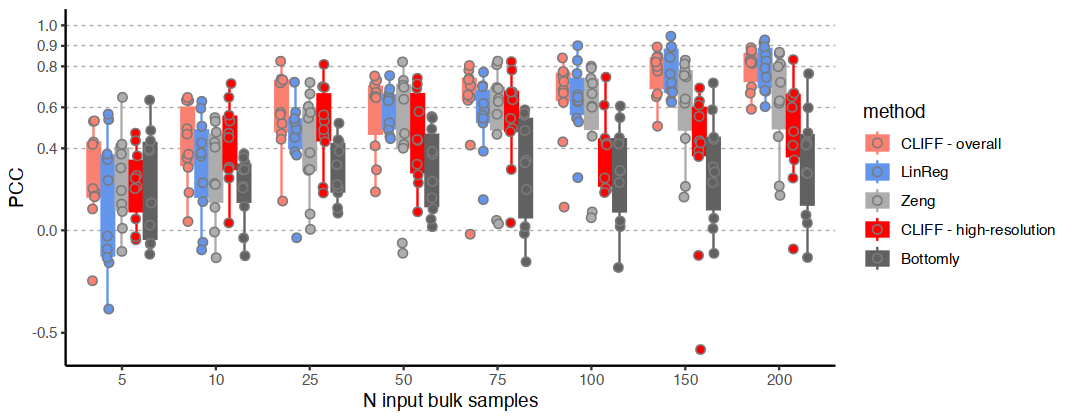

In [342]:
options(repr.plot.width=9, repr.plot.height=3.5)
g <- ggplot(cor_m, aes(x=sample, y=value, fill=method)) + 
    geom_hline(yintercept=c(0,0.4,0.6,0.8,0.9,1.0), color='grey68', size=0.3, linetype='dashed') + #geom_hline(yintercept=20) +
    geom_boxplot(outlier.shape = NA, aes(color=method)) + 
    geom_point(shape = 21, position = position_jitterdodge(jitter.width = 0.1), color='grey48', stroke=0.5, size=2) +
    scale_fill_manual(values = c('salmon', 'cornflowerblue', 'grey68', 'red', 'grey38')) +
    scale_color_manual(values = c('salmon', 'cornflowerblue', 'grey68', 'red', 'grey38')) +
    scale_y_continuous(breaks = c(-0.5, 0, 0.4, 0.6, 0.8, 0.9, 1.0)) + ylab('PCC') +
    xlab('N input bulk samples') + theme_classic()
pdf('results/fig5/boxplot_10simulationAML_N_bulks_4methods_FINAL_PCC.pdf', width=11, height=4) ; g ; dev.off()
g

In [293]:
rmse_cliff_overall_df = data.frame(rmse_cliff_overall_l) ; rmse_cliff_overall_df$sample = rownames(rmse_cliff_overall_df)
rmse_cliff_overall_m = melt(rmse_cliff_overall_df)
rmse_cliff_overall_m$sample = factor(rmse_cliff_overall_m$sample, levels=unique(rmse_cliff_overall_m$sample)[order(num(unique(rmse_cliff_overall_m$sample)))])
rmse_cliff_overall_m$method = 'CLIFF - overall'

Using sample as id variables



In [294]:
rmse_cliff_highres_df = data.frame(rmse_cliff_highres_l) ; rmse_cliff_highres_df$sample = rownames(rmse_cliff_highres_df)
rmse_cliff_highres_m = melt(rmse_cliff_highres_df)
rmse_cliff_highres_m$sample = factor(rmse_cliff_highres_m$sample, levels=unique(rmse_cliff_highres_m$sample)[order(num(unique(rmse_cliff_highres_m$sample)))])
rmse_cliff_highres_m$method = 'CLIFF - high-resolution'

Using sample as id variables



In [295]:
rmse_linreg_df = data.frame(rmse_linreg_l) ; rmse_linreg_df$sample = rownames(rmse_linreg_df)
rmse_linreg_m = melt(rmse_linreg_df)
rmse_linreg_m$sample = factor(rmse_linreg_m$sample, levels=unique(rmse_linreg_m$sample)[order(num(unique(rmse_linreg_m$sample)))])
rmse_linreg_m$method = 'LinReg'

Using sample as id variables



In [296]:
rmse_bottomly_df = data.frame(rmse_bottomly_l) ; rmse_bottomly_df$sample = rownames(rmse_bottomly_df)
rmse_bottomly_m = melt(rmse_bottomly_df)
rmse_bottomly_m$sample = factor(rmse_bottomly_m$sample, levels=unique(rmse_bottomly_m$sample)[order(num(unique(rmse_bottomly_m$sample)))])
rmse_bottomly_m$method = 'Bottomly'

Using sample as id variables



In [297]:
rmse_zeng_df = data.frame(rmse_zeng_l) ; rmse_zeng_df$sample = rownames(rmse_zeng_df)
rmse_zeng_m = melt(rmse_zeng_df)
rmse_zeng_m$sample = factor(rmse_zeng_m$sample, levels=unique(rmse_zeng_m$sample)[order(num(unique(rmse_zeng_m$sample)))])
rmse_zeng_m$method = 'Zeng'

Using sample as id variables



In [298]:
rmse_m = rbind(rmse_cliff_overall_m, rmse_cliff_highres_m, rmse_linreg_m, rmse_bottomly_m, rmse_zeng_m)

In [343]:
rmse_m$method = factor(rmse_m$method, levels=c('CLIFF - overall', 'CLIFF - high-resolution', 'LinReg', 'Zeng', 'Bottomly'))

pdf 
  2

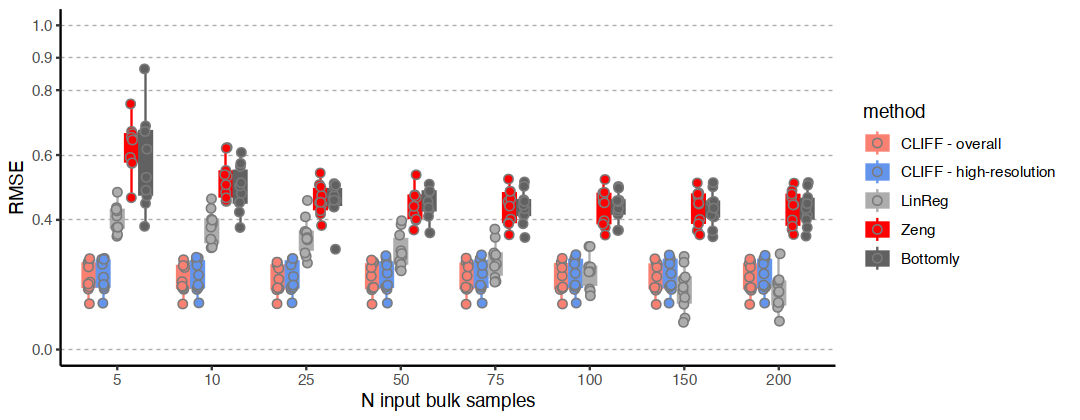

In [345]:
options(repr.plot.width=9, repr.plot.height=3.5)
g <- ggplot(rmse_m, aes(x=sample, y=value, fill=method)) + 
    geom_hline(yintercept=c(0,0.4,0.6,0.8,0.9,1.0), color='grey68', size=0.3, linetype='dashed') + #geom_hline(yintercept=20) +
    geom_boxplot(outlier.shape = NA, aes(color=method)) + 
    geom_point(shape = 21, position = position_jitterdodge(jitter.width = 0.1), color='grey48', stroke=0.5, size=2) +
    scale_fill_manual(values = c('salmon', 'cornflowerblue', 'grey68', 'red', 'grey38')) +
    scale_color_manual(values = c('salmon', 'cornflowerblue', 'grey68', 'red', 'grey38')) +
    scale_y_continuous(breaks = c(-0.5, 0, 0.4, 0.6, 0.8, 0.9, 1.0)) + ylab('PCC') +
    xlab('N input bulk samples') + theme_classic() + ylab('RMSE')
pdf('results/fig5/boxplot_10simulationAML_N_bulks_4methods_FINAL_RMSE.pdf', width=11, height=4) ; g ; dev.off()
g